<a href="https://colab.research.google.com/github/kirajcg/pyscbwrapper/blob/master/pyscbwrapper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inledning

Vi vill konstruera en graf över invånartätheten i varje län i Sverige över tid. Till vår hjälp har vi SCB:s data och Python, och vår målsättning är att inte lämna Pythonmiljön ens för att hämta datan. Lyckligtvis finns det ett särskilt utvecklat paket för detta ändamål, kallat pyscbwrapper. 

# Installation

pyscbwrapper är ett slags gränssnitt till statistikdatabasen, skrivet i Python 3. För att köra detta gränssnitt behöver vi först installera och importera det. 

In [0]:
!pip install -q pyscbwrapper
from pyscbwrapper import SCB

# Initiering

SCB är nu en klass vi har importerat, som innehåller funktioner för att navigera i statistikdatabasen och hämta både metadata och data från den. För att använda SCB-klassen behöver vi först initiera ett objekt från den. Då behövs ett obligatoriskt argument: språk för datan och metadatan. Engelska och svenska stöds. Vi väljer svenska: 

In [0]:
scb = SCB('sv')

# Navigering och metadata

Nu kan vi titta på toppnoden i det träd som är statistikdatabasens metadata: 

In [0]:
scb.info()

[{'id': 'AA', 'text': 'Ämnesövergripande statistik', 'type': 'l'},
 {'id': 'AM', 'text': 'Arbetsmarknad', 'type': 'l'},
 {'id': 'BE', 'text': 'Befolkning', 'type': 'l'},
 {'id': 'BO', 'text': 'Boende, byggande och bebyggelse', 'type': 'l'},
 {'id': 'EN', 'text': 'Energi', 'type': 'l'},
 {'id': 'FM', 'text': 'Finansmarknad', 'type': 'l'},
 {'id': 'HA', 'text': 'Handel med varor och tjänster', 'type': 'l'},
 {'id': 'HE', 'text': 'Hushållens ekonomi', 'type': 'l'},
 {'id': 'HS', 'text': 'Hälso- och sjukvård', 'type': 'l'},
 {'id': 'JO', 'text': 'Jord- och skogsbruk, fiske', 'type': 'l'},
 {'id': 'KU', 'text': 'Kultur och fritid', 'type': 'l'},
 {'id': 'LE', 'text': 'Levnadsförhållanden', 'type': 'l'},
 {'id': 'ME', 'text': 'Demokrati', 'type': 'l'},
 {'id': 'MI', 'text': 'Miljö', 'type': 'l'},
 {'id': 'NR', 'text': 'Nationalräkenskaper', 'type': 'l'},
 {'id': 'NV', 'text': 'Näringsverksamhet', 'type': 'l'},
 {'id': 'OE', 'text': 'Offentlig ekonomi', 'type': 'l'},
 {'id': 'PR', 'text': 'Pr

Vi kan nu gå ned i trädet med hjälp av id-taggen i metadatan vi fick ut. Säg att vi är intresserade av befolkningsstatistiken: 

In [0]:
scb.go_down('BE')

För att nu få fram metadata om befolkningsstatistiken kör vi återigen funktionen info():

In [0]:
scb.info()

[{'id': 'BE0001', 'text': 'Namnstatistik', 'type': 'l'},
 {'id': 'BE0101', 'text': 'Befolkningsstatistik', 'type': 'l'},
 {'id': 'BE0205',
  'text': 'Tidigare folk- och bostadsräkningar 1960-1990 (FoB)',
  'type': 'l'},
 {'id': 'BE0401', 'text': 'Befolkningsframskrivningar', 'type': 'l'},
 {'id': 'BE0701', 'text': 'Demografisk analys (Demografi)', 'type': 'l'}]

Vi kan fortsätta gå ned i trädet: 

In [0]:
scb.go_down('BE0001')
scb.info()

[{'id': 'BE0001D', 'text': 'Nyfödda', 'type': 'l'},
 {'id': 'BE0001G', 'text': 'Samtliga folkbokförda', 'type': 'l'}]

Oops! Vi ville inte titta på namnstatistiken utan befolkningsstatistiken. Vi går upp ett steg igen och vidare ned till rätt nod: 

In [0]:
scb.go_up()
scb.go_down('BE0101')
scb.info()

[{'id': 'BE0101A', 'text': 'Folkmängd', 'type': 'l'},
 {'id': 'BE0101B', 'text': 'Medelålder', 'type': 'l'},
 {'id': 'BE0101C', 'text': 'Befolkningstäthet', 'type': 'l'},
 {'id': 'BE0101D', 'text': 'Medelfolkmängd', 'type': 'l'},
 {'id': 'BE0101E', 'text': 'Utrikes födda', 'type': 'l'},
 {'id': 'BE0101F', 'text': 'Utländska medborgare', 'type': 'l'},
 {'id': 'BE0101G', 'text': 'Befolkningsförändringar', 'type': 'l'},
 {'id': 'BE0101H', 'text': 'Födda', 'type': 'l'},
 {'id': 'BE0101I', 'text': 'Döda', 'type': 'l'},
 {'id': 'BE0101J', 'text': 'Flyttningar - inrikes och utrikes', 'type': 'l'},
 {'id': 'BE0101S', 'text': 'Hushåll', 'type': 'l'},
 {'id': 'BE0101L', 'text': 'Gifta, Skilda och Änka/änkling', 'type': 'l'},
 {'id': 'BE0101N', 'text': 'Medborgarskapsbyten', 'type': 'l'},
 {'id': 'BE0101O', 'text': 'Partnerskap', 'type': 'l'},
 {'id': 'BE0101P', 'text': 'Asylsökande', 'type': 'l'},
 {'id': 'BE0101Q', 'text': 'Utländsk/svensk bakgrund', 'type': 'l'},
 {'id': 'BE0101K', 'text': 'Ad

# Direktväg till specifika noder

Om vi vet vart vi vill i trädet är det möjligt att initiera ett objekt med id-taggarna som extra variabler:

In [0]:
scb = SCB('sv', 'BE', 'BE0101')
scb.info()

[{'id': 'BE0101A', 'text': 'Folkmängd', 'type': 'l'},
 {'id': 'BE0101B', 'text': 'Medelålder', 'type': 'l'},
 {'id': 'BE0101C', 'text': 'Befolkningstäthet', 'type': 'l'},
 {'id': 'BE0101D', 'text': 'Medelfolkmängd', 'type': 'l'},
 {'id': 'BE0101E', 'text': 'Utrikes födda', 'type': 'l'},
 {'id': 'BE0101F', 'text': 'Utländska medborgare', 'type': 'l'},
 {'id': 'BE0101G', 'text': 'Befolkningsförändringar', 'type': 'l'},
 {'id': 'BE0101H', 'text': 'Födda', 'type': 'l'},
 {'id': 'BE0101I', 'text': 'Döda', 'type': 'l'},
 {'id': 'BE0101J', 'text': 'Flyttningar - inrikes och utrikes', 'type': 'l'},
 {'id': 'BE0101S', 'text': 'Hushåll', 'type': 'l'},
 {'id': 'BE0101L', 'text': 'Gifta, Skilda och Änka/änkling', 'type': 'l'},
 {'id': 'BE0101N', 'text': 'Medborgarskapsbyten', 'type': 'l'},
 {'id': 'BE0101O', 'text': 'Partnerskap', 'type': 'l'},
 {'id': 'BE0101P', 'text': 'Asylsökande', 'type': 'l'},
 {'id': 'BE0101Q', 'text': 'Utländsk/svensk bakgrund', 'type': 'l'},
 {'id': 'BE0101K', 'text': 'Ad

Som du ser hamnar vi direkt i befolkningsstatistiken.

---


Objektets specifika initiering hindrar oss dock inte från att navigera i trädet: 

In [0]:
scb.go_up()
scb.info()

[{'id': 'BE0001', 'text': 'Namnstatistik', 'type': 'l'},
 {'id': 'BE0101', 'text': 'Befolkningsstatistik', 'type': 'l'},
 {'id': 'BE0205',
  'text': 'Tidigare folk- och bostadsräkningar 1960-1990 (FoB)',
  'type': 'l'},
 {'id': 'BE0401', 'text': 'Befolkningsframskrivningar', 'type': 'l'},
 {'id': 'BE0701', 'text': 'Demografisk analys (Demografi)', 'type': 'l'}]

Hursomhelst, vi går tillbaka direkt till befolkningstäthet:

In [0]:
scb.go_down('BE0101', 'BE0101C')
scb.info()

[{'id': 'BefArealTathetKon',
  'text': 'Befolkningstäthet (invånare per kvadratkilometer), folkmängd och landareal efter region och kön. År 1991 - 2018',
  'type': 't',
  'updated': '2019-03-07T09:30:00'}]

Nu finns det bara en nod att gå till så vi gör det: 

In [0]:
scb.go_down('BefArealTathetKon')
scb.info()

{'title': 'Befolkningstäthet (invånare per kvadratkilometer) m.m efter region, kön, tabellinnehåll och år',
 'variables': [{'code': 'Region',
   'elimination': True,
   'text': 'region',
   'valueTexts': ['Riket',
    'Stockholms län',
    'Upplands Väsby',
    'Vallentuna',
    'Österåker',
    'Värmdö',
    'Järfälla',
    'Ekerö',
    'Huddinge',
    'Botkyrka',
    'Salem',
    'Haninge',
    'Tyresö',
    'Upplands-Bro',
    'Nykvarn',
    'Täby',
    'Danderyd',
    'Sollentuna',
    'Stockholm',
    'Södertälje',
    'Nacka',
    'Sundbyberg',
    'Solna',
    'Lidingö',
    'Vaxholm',
    'Norrtälje',
    'Sigtuna',
    'Nynäshamn',
    'Uppsala län',
    'Håbo',
    'Älvkarleby',
    'Knivsta',
    'Heby',
    'Tierp',
    'Uppsala',
    'Enköping',
    'Östhammar',
    'Södermanlands län',
    'Vingåker',
    'Gnesta',
    'Nyköping',
    'Oxelösund',
    'Flen',
    'Katrineholm',
    'Eskilstuna',
    'Strängnäs',
    'Trosa',
    'Östergötlands län',
    'Ödeshög',
    'Yd

Notera hur metadatan skiljer sig åt från föregående noder: Nyckelordet variables finns, och detta indikerar att vi står i en slutnod. Härifrån kan vi därför hämta den faktiska datan. 

---

Det är inte är nödvändigt att kalla info() efter varje go_down() men det är en bra idé att göra ändå, om man inte är väldigt säker på hur databasen ser ut. 

# Hämta data

Nu när vi är i en slutnod kan vi titta på vilka variabler som finns, och deras värdemängder: 

In [0]:
scb.get_variables()

{'kön': ['män', 'kvinnor', 'totalt'],
 'region': ['Riket',
  'Stockholms län',
  'Upplands Väsby',
  'Vallentuna',
  'Österåker',
  'Värmdö',
  'Järfälla',
  'Ekerö',
  'Huddinge',
  'Botkyrka',
  'Salem',
  'Haninge',
  'Tyresö',
  'Upplands-Bro',
  'Nykvarn',
  'Täby',
  'Danderyd',
  'Sollentuna',
  'Stockholm',
  'Södertälje',
  'Nacka',
  'Sundbyberg',
  'Solna',
  'Lidingö',
  'Vaxholm',
  'Norrtälje',
  'Sigtuna',
  'Nynäshamn',
  'Uppsala län',
  'Håbo',
  'Älvkarleby',
  'Knivsta',
  'Heby',
  'Tierp',
  'Uppsala',
  'Enköping',
  'Östhammar',
  'Södermanlands län',
  'Vingåker',
  'Gnesta',
  'Nyköping',
  'Oxelösund',
  'Flen',
  'Katrineholm',
  'Eskilstuna',
  'Strängnäs',
  'Trosa',
  'Östergötlands län',
  'Ödeshög',
  'Ydre',
  'Kinda',
  'Boxholm',
  'Åtvidaberg',
  'Finspång',
  'Valdemarsvik',
  'Linköping',
  'Norrköping',
  'Söderköping',
  'Motala',
  'Vadstena',
  'Mjölby',
  'Jönköpings län',
  'Aneby',
  'Gnosjö',
  'Mullsjö',
  'Habo',
  'Gislaved',
  'Vaggery

När vi har dessa kan vi välja vad vi är intresserade av och skapa en jsonfråga. Säg att vi är intresserade av invånare per kvadratkilometer i Örebro län för de senaste fem åren. 

In [0]:
scb.set_query(region=["Örebro län"], 
              tabellinnehåll=["Invånare per kvadratkilometer"], 
              år=["2014", "2015", "2016", "2017", "2018"])

Nu kan vi kolla hur frågan ser ut: 

In [0]:
scb.get_query()

{'query': [{'code': 'Region',
   'selection': {'filter': 'item', 'values': ['18']}},
  {'code': 'ContentsCode',
   'selection': {'filter': 'item', 'values': ['BE0101U1']}},
  {'code': 'Tid',
   'selection': {'filter': 'item',
    'values': ['2014', '2015', '2016', '2017', '2018']}}],
 'response': {'format': 'json'}}

Frågan blir automatiskt formaterad på rätt sätt för att hämta datan från API:et. Vi hämtar datan: 

In [0]:
scb.get_data()

{'columns': [{'code': 'Region', 'text': 'region', 'type': 'd'},
  {'code': 'Tid', 'text': 'år', 'type': 't'},
  {'code': 'BE0101U1', 'text': 'Invånare per kvadratkilometer', 'type': 'c'}],
 'comments': [],
 'data': [{'key': ['18', '2014'], 'values': ['33.9']},
  {'key': ['18', '2015'], 'values': ['34.2']},
  {'key': ['18', '2016'], 'values': ['34.7']},
  {'key': ['18', '2017'], 'values': ['35.1']},
  {'key': ['18', '2018'], 'values': ['35.5']}]}

Detta är samma data som man kan hämta från statistikdatabasen på hemsidan. Genom en funktion i pyscbwrapper kan vi få ut URL:en till sidan med datan: 

In [0]:
scb.get_url()

'http://www.statistikdatabasen.scb.se/pxweb/sv/ssd/START__BE__BE0101__BE0101C/BefArealTathetKon'

# Mer avancerade anrop

Nu när vi har sett hur datan ser ut kan vi plocka fram mer av den för att göra intressanta grafer. Eftersom vi redan är på rätt plats i API-strukturen behöver vi bara skapa en ny fråga. Säg att vi vill ha data från alla år från alla län. Vi kan först ta ut en lista över alla regioner, filtrera ut länen med hjälp av reguljära uttryck, och därefter använda listan i jsonfrågan: 

In [0]:
import re

regioner = scb.get_variables()['region']
r = re.compile(r'.* län')
lan = list(filter(r.match, regioner))

scb.set_query(region=lan,
              tabellinnehåll=["Invånare per kvadratkilometer"])

In [0]:
scb.get_query()

{'query': [{'code': 'Region',
   'selection': {'filter': 'item',
    'values': ['01',
     '03',
     '04',
     '05',
     '06',
     '07',
     '08',
     '09',
     '10',
     '12',
     '13',
     '14',
     '17',
     '18',
     '19',
     '20',
     '21',
     '22',
     '23',
     '24',
     '25']}},
  {'code': 'ContentsCode',
   'selection': {'filter': 'item', 'values': ['BE0101U1']}}],
 'response': {'format': 'json'}}

Det där är precis det frågan vi behöver nu. Vi tar ut datan och placerar den i en variabel så vi kan använda den senare: 

In [0]:
scb_data = scb.get_data()

I god sed tittar vi på datan innan vi gör någonting mer: 

In [0]:
scb_data

{'columns': [{'code': 'Region', 'text': 'region', 'type': 'd'},
  {'code': 'Tid', 'text': 'år', 'type': 't'},
  {'code': 'BE0101U1', 'text': 'Invånare per kvadratkilometer', 'type': 'c'}],
 'comments': [{'comment': 'Fr o m 2007-01-01 utökas Uppsala län med Heby kommun. Observera att länssiffrorna inte är jämförbara med länssiffrorna bakåt i tiden.\r\n',
   'value': '03',
   'variable': 'Region'},
  {'comment': 'Fr o m 2007-01-01 minskar Västmanlands län med Heby kommun. Observera att länssiffrorna inte är jämförbara med länssiffrorna bakåt i tiden.\r\n',
   'value': '19',
   'variable': 'Region'}],
 'data': [{'key': ['01', '1991'], 'values': ['254.9']},
  {'key': ['01', '1992'], 'values': ['257.3']},
  {'key': ['01', '1993'], 'values': ['259.8']},
  {'key': ['01', '1994'], 'values': ['263.2']},
  {'key': ['01', '1995'], 'values': ['265.9']},
  {'key': ['01', '1996'], 'values': ['268.8']},
  {'key': ['01', '1997'], 'values': ['271.6']},
  {'key': ['01', '1998'], 'values': ['274.8']},
  

Själva datan vi söker ligger nu här: 

In [0]:
scb_uttag = scb_data['data']

Än en gång kontrollerar vi att vi har fått fram rätt data: 

In [0]:
scb_uttag

[{'key': ['01', '1991'], 'values': ['254.9']},
 {'key': ['01', '1992'], 'values': ['257.3']},
 {'key': ['01', '1993'], 'values': ['259.8']},
 {'key': ['01', '1994'], 'values': ['263.2']},
 {'key': ['01', '1995'], 'values': ['265.9']},
 {'key': ['01', '1996'], 'values': ['268.8']},
 {'key': ['01', '1997'], 'values': ['271.6']},
 {'key': ['01', '1998'], 'values': ['274.8']},
 {'key': ['01', '1999'], 'values': ['276.6']},
 {'key': ['01', '2000'], 'values': ['279.7']},
 {'key': ['01', '2001'], 'values': ['282.1']},
 {'key': ['01', '2002'], 'values': ['283.8']},
 {'key': ['01', '2003'], 'values': ['285.4']},
 {'key': ['01', '2004'], 'values': ['287.3']},
 {'key': ['01', '2005'], 'values': ['289.9']},
 {'key': ['01', '2006'], 'values': ['294.2']},
 {'key': ['01', '2007'], 'values': ['299.0']},
 {'key': ['01', '2008'], 'values': ['303.9']},
 {'key': ['01', '2009'], 'values': ['309.7']},
 {'key': ['01', '2010'], 'values': ['315.1']},
 {'key': ['01', '2011'], 'values': ['320.5']},
 {'key': ['01

Nu behöver vi förstå strukturen på datan. Vi har fått ut en lista av dictionaries där den första variabeln key innehåller domänen (i detta fall län och år), och variabeln values innehåller värdet på undersökningsvariabeln (i detta fall invånare per kvadratkilometer). För att omforma detta till tidsserier som kan användas för visualisering krävs en del syntaktiska trick som beskrivs nedan. 

# Bearbetning av data

Vad vi söker är en tidsserie per län. Vi behöver därför strukturera om datan vi har fått ut innan vi kan göra någonting. Detta är utanför funktionaliteten hos pyscbwrapper, men vi kan lösa det med smidighet. En bra struktur vore en dictionary med län som nyckel och en annan dictionary som värde, där den inre dictionarien har år som nyckel och variabelvärde som värde. För detta tar vi fram listan över län som vi skapade tidigare och kopplar dem mot länkoderna, som vi kan plocka från dess plats i get_query(), i vårt fall 0. Genom att jämföra dessa koder, som är kopplade mot länsnamnen, med koderna i datan kan vi koppla länsnamnen mot datan. 

På så vis skapar vi strukturen vi vill ha, och passar på att göra värdena till numeriska. 

In [0]:
koder = scb.get_query()['query'][0]['selection']['values']

landic = {}
for i in range(len(koder)):
  landic[koder[i]] = lan[i]


landata = {}

for kod in landic:
  landata[landic[kod]] = {}
  for i in range(len(scb_uttag)):
    if scb_uttag[i]['key'][0] == kod:
      landata[landic[kod]][scb_uttag[i]['key'][1]] = \
      float(scb_uttag[i]['values'][0])


Det här blev ganska hackigt, så låt oss se om vad vi fick ut har den struktur vi sökte: 

In [0]:
landata

{'Blekinge län': {'1991': 51.4,
  '1992': 51.4,
  '1993': 51.6,
  '1994': 52.0,
  '1995': 51.9,
  '1996': 51.7,
  '1997': 51.6,
  '1998': 51.5,
  '1999': 51.1,
  '2000': 51.0,
  '2001': 50.9,
  '2002': 50.9,
  '2003': 50.9,
  '2004': 51.0,
  '2005': 51.1,
  '2006': 51.4,
  '2007': 51.5,
  '2008': 51.7,
  '2009': 51.8,
  '2010': 52.0,
  '2011': 52.2,
  '2012': 51.9,
  '2013': 52.1,
  '2014': 52.6,
  '2015': 53.3,
  '2016': 54.1,
  '2017': 54.4,
  '2018': 54.5},
 'Dalarnas län': {'1991': 10.3,
  '1992': 10.3,
  '1993': 10.3,
  '1994': 10.3,
  '1995': 10.3,
  '1996': 10.2,
  '1997': 10.1,
  '1998': 10.0,
  '1999': 10.0,
  '2000': 9.9,
  '2001': 9.8,
  '2002': 9.8,
  '2003': 9.8,
  '2004': 9.8,
  '2005': 9.8,
  '2006': 9.8,
  '2007': 9.8,
  '2008': 9.8,
  '2009': 9.8,
  '2010': 9.8,
  '2011': 9.9,
  '2012': 9.8,
  '2013': 9.9,
  '2014': 10.0,
  '2015': 10.0,
  '2016': 10.2,
  '2017': 10.2,
  '2018': 10.2},
 'Gotlands län': {'1991': 18.3,
  '1992': 18.3,
  '1993': 18.4,
  '1994': 18.5,
  '1

Det ser ju rätt ut. Nu kan vi loopa över nycklarna och plotta värdena med nyckel på x-axeln och värde på y-axeln. 

# Visualisering av data

Vi behöver numpy, pandas och matplotlib för detta. Vi installerar och importerar. 

In [0]:
!pip install -q matplotlib
!pip install -q pandas
!pip install -q numpy

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

Nu kan vi ta fram en trevlig graf.

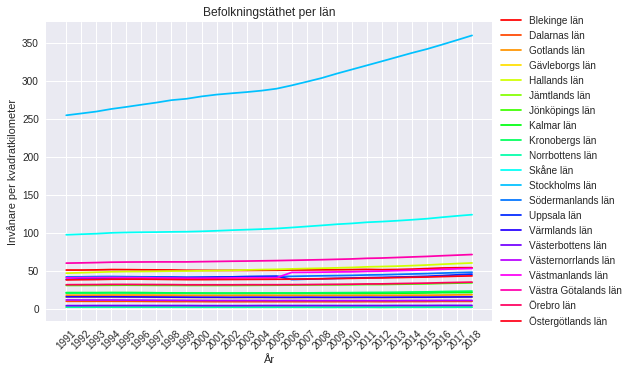

In [0]:
df = pd.DataFrame(landata)
df = df.reset_index()
df = df.rename(columns={"index":"År"})
ax = df.plot(x=df.index, xticks=np.arange(len(df.index)), colormap='hsv')
ax.set_xticklabels(df["År"], rotation=45)
plt.title("Befolkningstäthet per län")
plt.xlabel("År")
plt.ylabel("Invånare per kvadratkilometer")
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

Nu har vi vad vi ville, och vi lämnade aldrig Pythonmiljön!